# **Predicting which businesses are unlikely to pay their fines**

### A project in the subject of Machine Learning.


Ants Adamson, Erle Maido, Karl Soosalu, Kersti Mikkov

Institute of Computer Science

University of Taru

Tartu, December 16th 2024

## The background

All legal entities in Estonia are registered in the Estonian Business
Register. While a business is registered, they have the duty to keep their
data up to date in the register and submit an annual fiscal report. Failing to do either, can result in the business being fined.

There are thousands of fines issued by the Business Register every year. The levels of fines being paid by legal entities are not good.

Our goal is to find the legal entities that are unlikely to pay their fines and to do so even before the fine is issued. There is a real life use case and a successful project could help improve the Estonian business environment.


## The objective

At the start of the project we set ourselves a target of 75% accuracy with our predictions.

# 0. Setting up the project



## 0.1 Packages used in the notebook

In [97]:
import pandas as pd
import numpy as np
import random
from google.colab import drive
import zipfile
from sklearn.linear_model import Ridge, Lasso, LogisticRegression, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_recall_curve, auc, matthews_corrcoef
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

## 0.2 Data files

The data for the project comes in 5 .csv files:
- ML_P09_1legal_entities1.csv
- ML_P09_1legal_entities2.csv
- ML_P09_2phys_persons.csv
- ML_P09_3relations.csv
- phys_persons_roles.csv

All files are available in the github repository. The first 4 files are available as .zip files for easier/quicker movement of the files and should be unzipped before running this notebook.

We will provide two options to upload the files:
- please follow point **0.2a** if you are saving the files to your **Google drive** and skip 0.2b
- please follow point **0.2b** if you are **uploading the files** and skip 0.2a

<font color = 'purple'> **NB!** We have been given permission to use these data files for the duration and for the purpose of this ML project only. We kindly ask you to delete all data files from any drives you might have saved them to after they are no longer needed for running the ML model. Thank you!

## 0.2a Data on Google drive

If the data sets are on Google drive, please use the below two cells to upload the data to the notebook.

<font color = 'purple'> NB! Adjust the Google Drive path according to your own set-up on your drive.

NB! Please un-zip any zipped files before continuing.

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
file_path_data_entities_1 = '/content/drive/My Drive/Machine_learning_2024/Project/ML_P09_1legal_entities1.csv'
file_path_data_entities_2 = '/content/drive/My Drive/Machine_learning_2024/Project/ML_P09_1legal_entities2.csv'
file_path_data_persons = '/content/drive/My Drive/Machine_learning_2024/Project/ML_P09_2phys_persons.csv'
file_path_data_relations = '/content/drive/My Drive/Machine_learning_2024/Project/ML_P09_3relations.csv'
file_path_roles = '/content/drive/My Drive/Machine_learning_2024/Project/phys_persons_roles.csv'

In [111]:
# Joining the two separate legal_entities files into one

data_entities_1 = pd.read_csv(file_path_data_entities_1, encoding = 'iso-8859-1')
data_entities_2 = pd.read_csv(file_path_data_entities_2, encoding = 'iso-8859-1')

data_entities = pd.concat([data_entities_1, data_entities_2], ignore_index = True)

# Defining persons, relations and roles tables
data_persons = pd.read_csv(file_path_data_persons, encoding='iso-8859-1')
data_relations = pd.read_csv(file_path_data_relations, encoding='iso-8859-1')
data_roles = pd.read_csv(file_path_roles, encoding='iso-8859-1')

<ipython-input-111-c3f3e9914f58>:4: DtypeWarning: Columns (68,69,70,71,72,74,75,76,77,78,80,81,82,83,84,86,87,88,89,90,92,93,94,95,96,98,99,100,101,102) have mixed types. Specify dtype option on import or set low_memory=False.
  data_entities_2 = pd.read_csv(file_path_data_entities_2, encoding = 'iso-8859-1')
<ipython-input-111-c3f3e9914f58>:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data_persons = pd.read_csv(file_path_data_persons, encoding='iso-8859-1')


## 0.2b Upload data from file

If you are uploading the files from your computer, please use the following two cells.

NB! Please make sure to unzip the files before uploading.

In [ ]:
files.upload();

In [ ]:
# Joining the two separate legal_entities files into one

data_entities_1 = pd.read_csv("ML_P09_1legal_entities1.csv", encoding = 'iso-8859-1')
data_entities_2 = pd.read_csv("ML_P09_1legal_entities2.csv", encoding = 'iso-8859-1')

data_entities = pd.concat([data_entities_1, data_entities_2], ignore_index = True)

# Defining persons, relations and roles tables
data_persons = pd.read_csv("ML_P09_2phys_persons.csv", encoding = 'iso-8859-1')
data_relations = pd.read_csv("ML_P09_3relations.csv", encoding = 'iso-8859-1')
data_roles = pd.read_csv("phys_persons_roles.csv", encoding = 'iso-8859-1')

## 0.3 Define a plot to be used later in the project

In [112]:
def plot_class_distribution(y, title = "Class Distribution"):

    class_counts = y.value_counts()

    class_counts.plot(kind = 'bar', color = ['navy', 'skyblue'])
    plt.title(title, fontsize = 14)
    plt.xlabel("Class", fontsize = 12)
    plt.ylabel("Frequency", fontsize = 12)
    plt.xticks(rotation = 0, fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.tight_layout()
    plt.show()

# 1. Restructuring initial columns

In this section, we are:
*   Defining the target value
*   Removing and summing columns
*   Changing data types

## 1.1 Defining target value y

`y` is used as a lable to show whether the entity is likely to pay their fine or not.

- `y = 0` - the entity is unlikely to pay the fine issued to them
- `y = 1` - the entity is likely to pay the fine issued to them

We calculate the taget value by:
1. Calculating the proportion of fines an entity has paid out of all fines they have received.
2. Assigning a target value y based on the above proportion - if the proportion of fines paid is > 0.5, they will be assigned into `y = 1` (likely to pay). Otherwise they will be assigned into `y = 0` (unlikely to pay).

In [113]:
# Defining the columns that include fines
fines = ['H...2017', 'H...2018', 'H...2019', 'H...2020', 'H...2021', 'H...2022', 'H...2023', 'H...2024',
                      'H2...2022', 'H2...2023', 'T...2023', 'T...2024',
                      'R...2023', 'R...2024', 'KO...2023', 'KO...2024', 'KO2...2023', 'KO2...2024']

In [114]:
# Count fines received and not paid (0)
data_entities['fine_not_paid_count'] = (data_entities[fines] == 0).sum(axis=1)

# Count fines received and paid (1)
data_entities['fine_paid_count'] = (data_entities[fines] == 1).sum(axis=1)

In [115]:
# Counting the number of fines received by the business in total
data_entities['fine_count'] = data_entities['fine_not_paid_count'] + data_entities['fine_paid_count']

In [116]:
# Adding entities that have not been fined into a separate table
entities_not_fined = data_entities[data_entities['fine_count'] == 0].copy()

In [117]:
# Create a separate table for entities that have been fined and therefore have a label (target value)
# Remove rows where fine_count == 0 to create a main table of entities that have been fined
data_entities = data_entities.loc[data_entities['fine_count'] != 0].copy()

# Calculate the target label fine_paid_class
data_entities['fine_paid_class'] = (data_entities['fine_paid_count'] / data_entities['fine_count'] > 0.5).astype(int)

In [118]:
# Removing all the separate fine columns from the data
data_entities.drop(fines, axis = 1, inplace = True)
data_entities.drop(['fine_not_paid_count', 'fine_paid_count', 'fine_count'], axis = 1, inplace = True)

In [119]:
data_entities.shape

(20820, 93)

## 1.2 Removing and summing columns

### 1.2.1 Restructuring warning columns in entities table

In [120]:
# Defining the columns that include warnings
warnings = [
    "HM...2021", "HM...2022", "HM...2023", "X2...2022", "X2...2023",
    "Y3...2020", "Y3...2021", "Y3...2022", "Y3...2023", "I1...2023",
    "I1...2024", "K2...2023", "K2...2024", "GY...2023", "GY...2024",
    "KI...2023", "KI...2024", "HM...2017", "I2...2023", "G1...2024",
    "Y3...2018", "Y3...2019", "X2...2021", "Y2...2022", "Y2...2023",
    "I1...2021", "HM...2020", "G1...2023", "HM...2013"
]

# Calculate the sum of these columns for each entity
data_entities["sum_warnings"] = data_entities[warnings].sum(axis=1).astype(int)

In [121]:
# Removing all the separate warning columns from the data
data_entities.drop(warnings, axis = 1, inplace = True)

###1.2.2 Restructuring MAA late days columns in entities table

In [122]:
# Defining the columns that include fiscal year report late days
fyr_late_days = ['MAA_2023_late_days', 'MAA_2022_late_days', 'MAA_2021_late_days', 'MAA_2020_late_days', 'MAA_2019_late_days']

# Calculate mean late days, skipping NA values
data_entities['mean_fyr_late_days'] = data_entities[fyr_late_days].mean(axis = 1, skipna = True)

# Removing all the separate fiscal year report late days columns from the data
data_entities.drop(fyr_late_days, axis = 1, inplace = True)

### 1.2.3 Restructuring MAA status columns in entities table

In [123]:
# Defining the columns that include fiscal year report status
fyr_status = ['MAA_2023_status', 'MAA_2022_status', 'MAA_2021_status', 'MAA_2020_status', 'MAA_2019_status']

# Calculate the percentage of fiscal year reports presented
data_entities['fyr_presented_p'] = data_entities[fyr_status].sum(axis=1, skipna=True) / data_entities[fyr_status].count(axis = 1)

# Remove the individual fiscal year status columns
data_entities.drop(fyr_status, axis = 1, inplace = True)

### 1.2.4 Removing unnecessary columns from entities table

These are columns that are either duplicating data in other columns or have been deemed not relevant for the current project.

In [124]:
# Drop the additional specified columns
columns_to_drop = ['date_registration', 'date_deletion', 'legal_form', 'activity', 'activity_field']
data_entities.drop(columns=columns_to_drop, inplace = True)

In [125]:
data_entities.head()

,le_ps_id,current_status,entity_age,legal_form_code,emtak,activity_field_code,X2023_1_sales_tax_reg,X2023_1_location,X2023_1_state_taxes,X2023_1_employment_taxes,...,X2024_3_sales_tax_reg,X2024_3_location,X2024_3_state_taxes,X2024_3_employment_taxes,X2024_3_revenue,X2024_3_employees,fine_paid_class,sum_warnings,mean_fyr_late_days,fyr_presented_p
28,ddHxQiWCmAdIX61ISro9,R,27,7,68321.0,L,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,59.20,1.0
33,DMNrMBMvcb0xMdATZ3rn,R,27,6,68201.0,L,ei,Harju ( Tallinn ),"3,11",0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,111.75,0.8
84,nSBwNaxQj2KfDxCT6Xkn,R,27,6,68321.0,L,ei,Harju ( Tallinn ),"379,88","257,08",...,NaN,NaN,NaN,NaN,NaN,NaN,0,2,67.80,1.0
95,TNJCiBDp0TJ65ORpGUwL,R,27,6,68321.0,L,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,659.00,1.0
150,nVHXzG0pHWPexz2kEJxg,R,27,5,41201.0,F,NaN,NaN,NaN,NaN,...,ei,Harju ( Tallinn ),"983,54","31,99",NaN,NaN,0,2,NaN,0.0


## 1.3 Changing data types

### 1.3.1 Converting columns ending with "sales_tax_reg" to numerical values

In [126]:
# Replace values in columns ending with "sales_tax_reg with numerical values"
sales_tax_reg_cols = [col for col in data_entities.columns if col.endswith("sales_tax_reg")]

# Apply replacements: 'jah' to 1, 'ei' to 0, and NA to -1
data_entities[sales_tax_reg_cols] = data_entities[sales_tax_reg_cols].replace(
    {'jah': 1, 'ei': 0}).fillna(-1).astype(int)

# Display the first few rows to verify the replacements
data_entities[sales_tax_reg_cols].head()

<ipython-input-126-b16e6945d340>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_entities[sales_tax_reg_cols] = data_entities[sales_tax_reg_cols].replace(


,X2023_1_sales_tax_reg,X2023_2_sales_tax_reg,X2023_3_sales_tax_reg,X2023_4_sales_tax_reg,X2024_1_sales_tax_reg,X2024_2_sales_tax_reg,X2024_3_sales_tax_reg
28,-1,-1,-1,-1,0,0,-1
33,0,0,-1,0,-1,0,-1
84,0,-1,-1,0,0,0,-1
95,-1,0,0,0,-1,0,-1
150,-1,-1,-1,-1,-1,-1,0


### 1.3.2 Converting columns with object data type to numerical values

In [127]:
# Columns to convert to numeric types based on their names
tax_revenue_cols = [col for col in data_entities.columns if col.endswith(("state_taxes", "employment_taxes", "revenue"))]

# Convert these columns to numeric, forcing errors to NaN where conversion may not apply
data_entities[tax_revenue_cols] = data_entities[tax_revenue_cols].apply(pd.to_numeric, errors = 'coerce')

# 2. Adding new features

## 2.1 Add column: how many active unique persons are connected with entity?

In [128]:
# Filter the relations data to get only current relationships
# Assuming 'ending_date' column represents the end of the relation and is in a date format, NA means still active
current_relations = data_relations[data_relations['ending_date'].isna()]

# Count the number of unique persons currently related to each legal entity
unique_current_person_count = current_relations.groupby('le_ps_id')['pp_ps_id'].nunique().reset_index(name = 'unique_current_person_count')

# Merge this unique count with the legal entities table
data_entities = pd.merge(data_entities, unique_current_person_count, left_on='le_ps_id', right_on = 'le_ps_id', how = 'left')

# Fill any NA values in the new column with 0, indicating no unique current persons related
data_entities['unique_current_person_count'] = data_entities['unique_current_person_count'].fillna(0).astype(int)

# Display the modified dataframe with the new column
data_entities[["le_ps_id", "unique_current_person_count"]].head()

,le_ps_id,unique_current_person_count
0,ddHxQiWCmAdIX61ISro9,3
1,DMNrMBMvcb0xMdATZ3rn,178
2,nSBwNaxQj2KfDxCT6Xkn,60
3,TNJCiBDp0TJ65ORpGUwL,5
4,nVHXzG0pHWPexz2kEJxg,1


## 2.2 Add column: how many active unique representitives are connected with entity?

In [129]:
# Filter roles for rows where seadusjargne_esindusoigus is True
representative_roles = data_roles[data_roles['seadusjargne_esindusoigus'] == True]

# Merge representative_roles with active_relations to get only active representatives
active_representatives = pd.merge(
    current_relations,
    representative_roles,
    left_on = 'role_in_entity',
    right_on = 'id',
    how = 'inner'
)

# Count the number of unique people (pp_ps_id) for each entity (le_ps_id)
count_active_representatives = (
    active_representatives.groupby('le_ps_id')['pp_ps_id']
    .nunique()
    .reset_index(name = 'count_active_representatives')
)

# Merge the count back to the entities table
data_entities = pd.merge(
    data_entities,
    count_active_representatives,
    on = 'le_ps_id',
    how = 'left'
)

# Fill NA values with 0 (no active representatives for those entities)
data_entities['count_active_representatives'] = data_entities['count_active_representatives'].fillna(0).astype(int)

# Display the updated entities table
data_entities[['le_ps_id', 'count_active_representatives']].head()

,le_ps_id,count_active_representatives
0,ddHxQiWCmAdIX61ISro9,3
1,DMNrMBMvcb0xMdATZ3rn,3
2,nSBwNaxQj2KfDxCT6Xkn,3
3,TNJCiBDp0TJ65ORpGUwL,1
4,nVHXzG0pHWPexz2kEJxg,1


## 2.3 Add column: does entity have an active representative who is an active representative in at least 15 other unique entities?

In [130]:
# Count unique entities for each active representative
rep_entity_count = (
    active_representatives.groupby('pp_ps_id')['le_ps_id']
    .nunique()
    .reset_index(name = 'unique_entities_count')
)

# Filter representatives with at least 15 unique entities
reps_with_15_entities = rep_entity_count[rep_entity_count['unique_entities_count'] >= 15]

# Filter relationships for these representatives
entities_with_active_reps = active_representatives[
    active_representatives['pp_ps_id'].isin(reps_with_15_entities['pp_ps_id'])
]

# Mark entities with such representatives
data_entities['active_rep_with_15plus_entities_flag'] = data_entities['le_ps_id'].isin(
    entities_with_active_reps['le_ps_id']
).astype(int)

# Display the updated entities table
data_entities[['le_ps_id', 'active_rep_with_15plus_entities_flag']].head()

,le_ps_id,active_rep_with_15plus_entities_flag
0,ddHxQiWCmAdIX61ISro9,0
1,DMNrMBMvcb0xMdATZ3rn,0
2,nSBwNaxQj2KfDxCT6Xkn,0
3,TNJCiBDp0TJ65ORpGUwL,0
4,nVHXzG0pHWPexz2kEJxg,0


#3. Split the dataset into training and test sets

In [131]:
# Split the balanced dataset into training and test sets (80% training, 20% test)
train_data, test_data = train_test_split(data_entities, test_size = 0.2, random_state = 42)

# Display the number of samples in each set to verify
len(train_data), len(test_data)

(16656, 4164)

In [132]:
# Count the number of legal entities in training data whose fine paid class = 0
fine_payment_count = train_data['fine_paid_class'].apply(lambda x: 'Potentially not paying the fine' if x == 0 else 'Potentially pays the fine').value_counts()

# Display the counts
fine_payment_count

,count
fine_paid_class,
Potentially not paying the fine,12592
Potentially pays the fine,4064


In [133]:
# Count the number of legal entities in test data whose fine paid class = 0
test_fine_payment_count = test_data['fine_paid_class'].apply(lambda x: 'Potentially not paying the fine' if x == 0 else 'Potentially pays the fine').value_counts()

# Display the counts
test_fine_payment_count

,count
fine_paid_class,
Potentially not paying the fine,3157
Potentially pays the fine,1007


In [134]:
# Separating the target value from training and test data sets

X_train = train_data.drop(['fine_paid_class'], axis=1)
y_train = train_data['fine_paid_class']

X_test = test_data.drop(['fine_paid_class'], axis=1)
y_test = test_data['fine_paid_class']

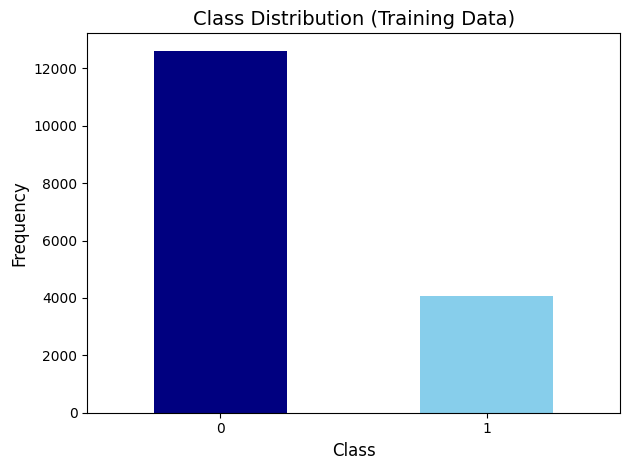

In [135]:
plot_class_distribution(y_train, "Class Distribution (Training Data)")

#4. Pre-processing the training and test data

##4.1 Imputing numerical and categorical values

In [136]:
# Removing the id column from training and test sets.
# This column is no longer needed, as the required engineered features have been added
# and the id column holds no other valuable information.

X_train = X_train.drop(['le_ps_id'], axis = 1)
X_test = X_test.drop(['le_ps_id'], axis = 1)

In [137]:
# Separate numerical and categorical columns
numerical_cols = X_train.select_dtypes(include = ['float64', 'int64']).columns
categorical_cols = X_train.select_dtypes(include = ['object']).columns

# Create imputers for numerical and categorical columns
numerical_imputer = SimpleImputer(strategy = 'constant', fill_value = -1)
categorical_imputer = SimpleImputer(strategy = 'constant', fill_value = 'unknown')

# Apply imputers to fill missing values
X_train[numerical_cols] = numerical_imputer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = numerical_imputer.transform(X_test[numerical_cols])

X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = categorical_imputer.transform(X_test[categorical_cols])

##4.2 Applying one-hot encoding

In [138]:
# Apply one-hot encoding to categorical columns
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

## 4.3 Addressing the Class Imbalance with SMOTE

In [140]:
# Applying SMOTE on the training set to balance the data
smote = SMOTE(random_state = 42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

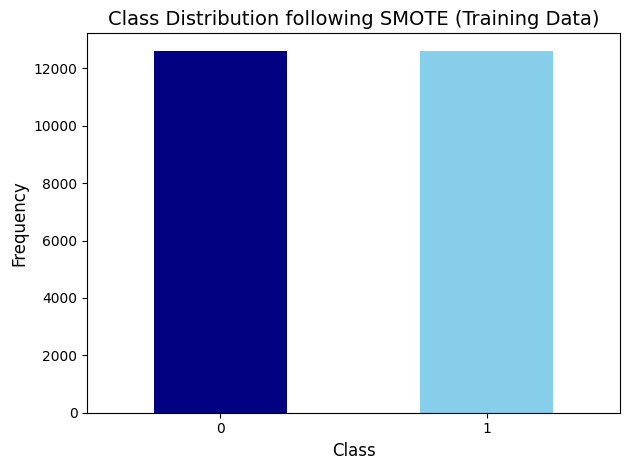

In [142]:
plot_class_distribution(y_train_resampled, "Class Distribution following SMOTE (Training Data)")

## 4.4 Feature selection with LASSO tool

In [143]:
# Using LASSO for feature selection

alpha = 0.03  # this is the regularisation parameter giving the best result
lasso = Lasso(alpha)

# Fitting Lasso on the training data
lasso.fit(X_train_resampled, y_train_resampled)

Lasso(alpha=0.03)

In [144]:
# Choosing the features where the weight != 0

feature_names = preprocessor.get_feature_names_out()
selected_features = feature_names[lasso.coef_ != 0]
print(f'There are {len(selected_features)} selected features and they are:', '\n', '\n'.join(selected_features))

There are 29 selected features and they are: 
 remainder__entity_age
remainder__emtak
remainder__X2023_1_state_taxes
remainder__X2023_1_employment_taxes
remainder__X2023_1_revenue
remainder__X2023_2_state_taxes
remainder__X2023_2_employment_taxes
remainder__X2023_2_revenue
remainder__X2023_3_state_taxes
remainder__X2023_3_employment_taxes
remainder__X2023_3_revenue
remainder__X2023_4_state_taxes
remainder__X2023_4_employment_taxes
remainder__X2023_4_revenue
remainder__X2024_1_state_taxes
remainder__X2024_1_employment_taxes
remainder__X2024_1_revenue
remainder__X2024_2_sales_tax_reg
remainder__X2024_2_state_taxes
remainder__X2024_2_employment_taxes
remainder__X2024_2_revenue
remainder__X2024_3_sales_tax_reg
remainder__X2024_3_state_taxes
remainder__X2024_3_employment_taxes
remainder__X2024_3_revenue
remainder__X2024_3_employees
remainder__mean_fyr_late_days
remainder__fyr_presented_p
remainder__unique_current_person_count


In [145]:
# Creating a training and test set with only the selected features

x_train = X_train_resampled[:, lasso.coef_ != 0]
x_test = X_test_encoded[:, lasso.coef_ != 0]

# 5. XGBoost model

## 5.1 Training the model

In [146]:
# Training the model
xgb_model = XGBClassifier(eval_metric = 'logloss', random_state = 42)
xgb_model.fit(x_train, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## 5.2 Perfomance metrics at default threshold of 0.5

### 5.2.1 Calculating the main performance metrics and the classification  report

In [147]:
# Predict class labels directly using the default threshold (0.5)
y_pred_xgb = xgb_model.predict(x_test)

# Evaluate the predictions
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
classification_report_xgb = classification_report(y_test, y_pred_xgb)
print("At default threshold of 0.5:")
print()
print("XGBoost Accuracy:", accuracy_xgb)
print("XGBoost Classification Report:\n", classification_report_xgb)

# Compute the ROC curve and AUC using raw probabilities
y_pred_prob_xgb = xgb_model.predict_proba(x_test)[:, 1]  # Raw probabilities for the positive class
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_prob_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)

# Print AUC
print("XGBoost AUC (Raw Probabilities):", auc_xgb)

# Compute Matthews Correlation Coeficient
mcc_xgb = matthews_corrcoef(y_test, y_pred_xgb)
print("XGBoost MCC:", mcc_xgb)

At default threshold of 0.5:

XGBoost Accuracy: 0.9032180595581172
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      3157
           1       0.80      0.80      0.80      1007

    accuracy                           0.90      4164
   macro avg       0.87      0.87      0.87      4164
weighted avg       0.90      0.90      0.90      4164

XGBoost AUC (Raw Probabilities): 0.9508837252315829
XGBoost MCC: 0.7368877723318492


### 5.2.2 Plotting the perfomance metrics results

### 5.2.2.1 ROC curve

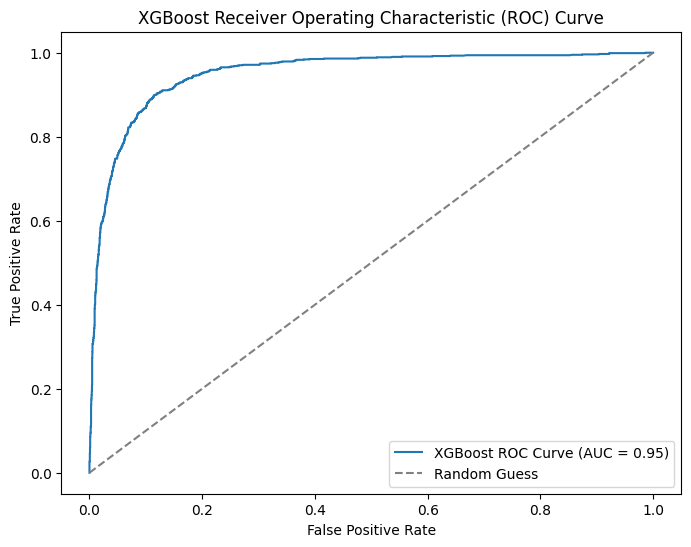

In [148]:
# Plot the ROC curve
plt.figure(figsize = (8, 6))
plt.plot(fpr_xgb, tpr_xgb, label = f"XGBoost ROC Curve (AUC = {auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = "Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

### 5.2.2.2 Precision-Recall Curve

XGBoost AUC PRC: 0.8629091519729105


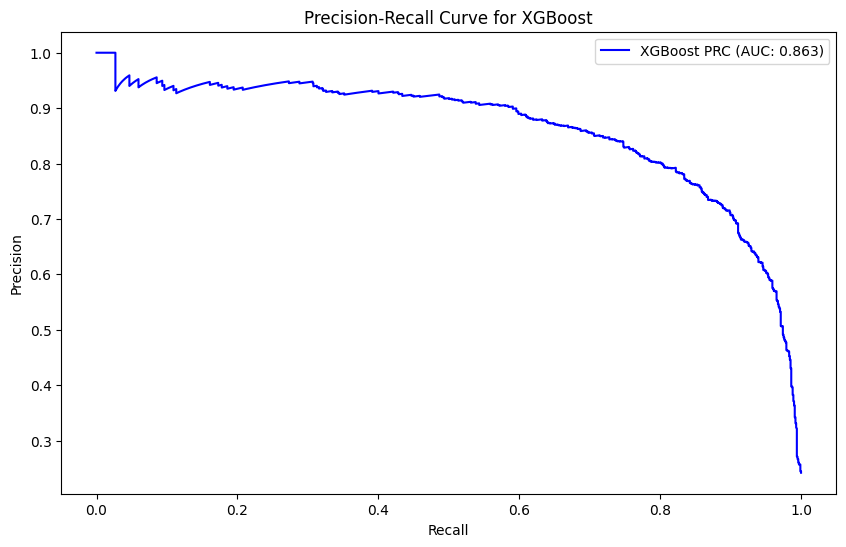

In [149]:
# Compute Precision-Recall Curve for XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_prob_xgb)
auc_prc_xgb = auc(recall_xgb, precision_xgb)

# Print AUC
print("XGBoost AUC PRC:", auc_prc_xgb)

# Plotting Precision-Recall Curve
plt.figure(figsize = (10, 6))
plt.plot(recall_xgb, precision_xgb, label = f'XGBoost PRC (AUC: {auc_prc_xgb:.3f})', color = 'blue')
plt.title('Precision-Recall Curve for XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### 5.2.3 Feature importance

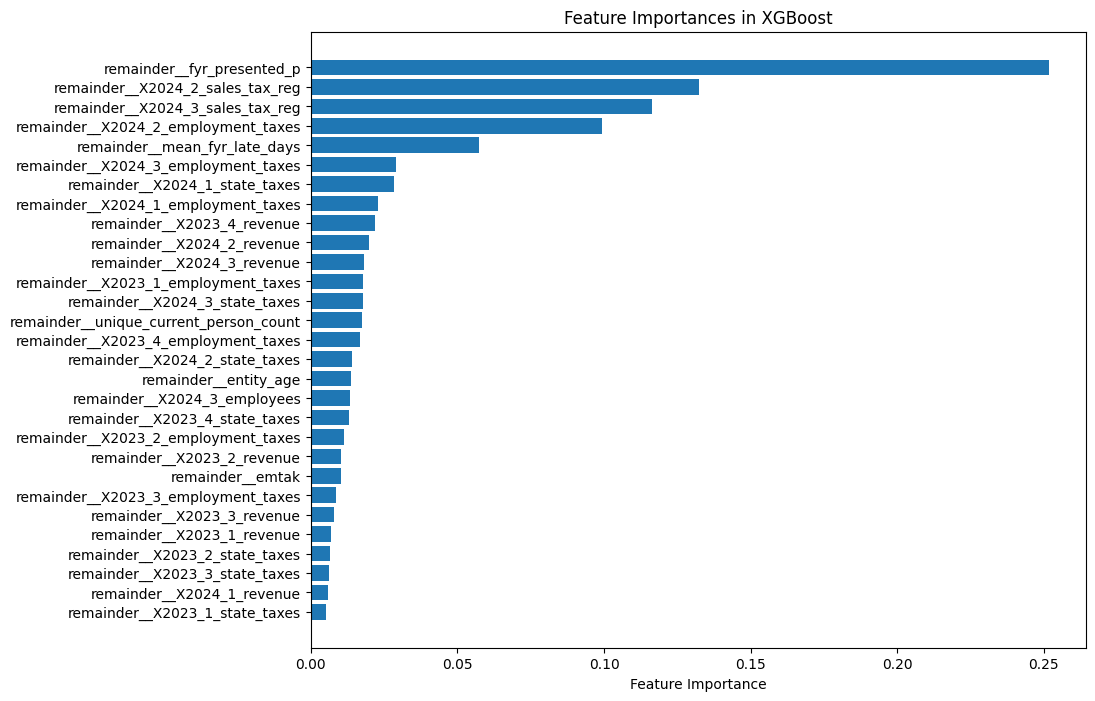

In [150]:
# Get feature importances
importance = xgb_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importance)[::-1]
sorted_feature_names = selected_features[indices]
sorted_importances = importance[indices]

# Plot feature importances
plt.figure(figsize = (10, 8))
plt.barh(sorted_feature_names[:30], sorted_importances[:30])
plt.xlabel("Feature Importance")
plt.title("Feature Importances in XGBoost")
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
plt.show()

## 5.3 Filtering prediction by confidence

We are looking at the results also from the perspective of the model confidence of predictions.

How confident is the model? And what percentage of entities would need to be checked by hand given different confidence levels?

In [152]:
y_pred_proba = xgb_model.predict_proba(x_test)

confidence_threshold = 0.90

# Filter predictions based on confidence
confident_predictions_mask = (y_pred_proba.max(axis = 1) >= confidence_threshold)
filtered_predictions = y_pred_xgb[confident_predictions_mask]
filtered_y_test = y_test[confident_predictions_mask]

# Calculate accuracy on filtered predictions
accuracy_filtered = accuracy_score(filtered_y_test, filtered_predictions)
print(f'At confidence threshold of {confidence_threshold}:')
print()
print(f"Accuracy on filtered predictions: {accuracy_filtered:.4f}")

# Calculate percentage of data for manual review
total_test_samples = len(y_test)
num_manual_review = total_test_samples - len(filtered_predictions)
percentage_manual_review = (num_manual_review / total_test_samples) * 100

print(f"Percentage of test data for manual review: {percentage_manual_review:.2f}%")

# Classification report for filtered predictions
print(f"\nClassification Report:")
print(classification_report(filtered_y_test, filtered_predictions))
print()
print(f"Matthews Correlation Coeficient of filtered predictions: {matthews_corrcoef(filtered_y_test, filtered_predictions)}")

At confidence threshold of 0.9:

Accuracy on filtered predictions: 0.9674
Percentage of test data for manual review: 23.41%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2626
           1       0.92      0.90      0.91       563

    accuracy                           0.97      3189
   macro avg       0.95      0.94      0.94      3189
weighted avg       0.97      0.97      0.97      3189


Matthews Correlation Coeficient of filtered predictions: 0.8868323767658621


# 6. Applying the model on unlabelled data

The real life application of this model will be to predict the likelyhood of a legal entity to pay a fine before the fine is issued.

Below we will test the model by predicting the likelyhood of a legal entity to pay their fine by applying the model on the unlabelled data in our original dataset.

The prediction is made for legal entities that have not been fined over the last few years and therefore have no labels to check against.

## 6.1 Preprocessing the unlabelled data for predicting

Here we go through all the same pre-processing steps as on the training and test data above, to bring the data to the shape required to do the predictions.

In [153]:
# Removing all the separate fine columns from the data
entities_not_fined.drop(fines, axis = 1, inplace = True)
entities_not_fined.drop(['fine_not_paid_count', 'fine_paid_count', 'fine_count'], axis = 1, inplace = True)

In [154]:
# Defining the columns that include warnings
warnings = [
    "HM...2021", "HM...2022", "HM...2023", "X2...2022", "X2...2023",
    "Y3...2020", "Y3...2021", "Y3...2022", "Y3...2023", "I1...2023",
    "I1...2024", "K2...2023", "K2...2024", "GY...2023", "GY...2024",
    "KI...2023", "KI...2024", "HM...2017", "I2...2023", "G1...2024",
    "Y3...2018", "Y3...2019", "X2...2021", "Y2...2022", "Y2...2023",
    "I1...2021", "HM...2020", "G1...2023", "HM...2013"
]

# Calculate the sum of these columns for each entity
entities_not_fined["sum_warnings"] = entities_not_fined[warnings].sum(axis=1).astype(int)

In [155]:
# Removing all the separate warning columns from the data
entities_not_fined.drop(warnings, axis = 1, inplace = True)

In [156]:
# Defining the columns that include fiscal year report late days
fyr_late_days = ['MAA_2023_late_days', 'MAA_2022_late_days', 'MAA_2021_late_days', 'MAA_2020_late_days', 'MAA_2019_late_days']

# Calculate mean late days, skipping NA values
entities_not_fined['mean_fyr_late_days'] = entities_not_fined[fyr_late_days].mean(axis = 1, skipna = True)

# Removing all the separate fiscal year report late days columns from the data
entities_not_fined.drop(fyr_late_days, axis = 1, inplace = True)

In [157]:
# Defining the columns that include fiscal year report status
fyr_status = ['MAA_2023_status', 'MAA_2022_status', 'MAA_2021_status', 'MAA_2020_status', 'MAA_2019_status']

# Calculate the percentage of fiscal year reports presented
entities_not_fined['fyr_presented_p'] = entities_not_fined[fyr_status].sum(axis=1, skipna=True) / entities_not_fined[fyr_status].count(axis=1)

# Remove the individual fiscal year status columns
entities_not_fined.drop(fyr_status, axis=1, inplace=True)

In [158]:
# Drop the additional specified columns
columns_to_drop = ['date_registration', 'date_deletion', 'legal_form', 'activity', 'activity_field']
entities_not_fined.drop(columns = columns_to_drop, inplace = True)

In [159]:
entities_not_fined.head()

,le_ps_id,current_status,entity_age,legal_form_code,emtak,activity_field_code,X2023_1_sales_tax_reg,X2023_1_location,X2023_1_state_taxes,X2023_1_employment_taxes,...,X2024_2_employees,X2024_3_sales_tax_reg,X2024_3_location,X2024_3_state_taxes,X2024_3_employment_taxes,X2024_3_revenue,X2024_3_employees,sum_warnings,mean_fyr_late_days,fyr_presented_p
0,P8utlbnFP8uBGnXX0dvd,R,27,23,68321.0,L,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,BVmIMUbTFCtch5vQ4xgO,R,27,7,6832.0,L,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,43.0,1.0
2,CApXqnXt88Hggqs9MDx6,R,27,23,68321.0,L,ei,NaN,120,0,...,NaN,ei,NaN,40,0,NaN,NaN,0,1.0,1.0
3,dlIHW2OD8LuQ9xq9go5g,R,27,7,94999.0,S,ei,Harju ( Tallinn ),"2694,6","2817,36",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15.0,1.0
4,bxcf51yINqb0Txpyyly7,R,27,23,68321.0,L,ei,NaN,"89,1","95,58",...,1.0,ei,NaN,"59,4","63,72",NaN,1.0,0,127.0,0.4


In [160]:
# Replace values in columns ending with "sales_tax_reg with numerical values"
sales_tax_reg_cols = [col for col in entities_not_fined.columns if col.endswith("sales_tax_reg")]

# Apply replacements: 'jah' to 1, 'ei' to 0, and NA to -1
entities_not_fined[sales_tax_reg_cols] = entities_not_fined[sales_tax_reg_cols].replace(
    {'jah': 1, 'ei': 0}).fillna(-1).astype(int)

# Display the first few rows to verify the replacements
entities_not_fined[sales_tax_reg_cols].head()

<ipython-input-160-42abb2c6633f>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  entities_not_fined[sales_tax_reg_cols] = entities_not_fined[sales_tax_reg_cols].replace(


,X2023_1_sales_tax_reg,X2023_2_sales_tax_reg,X2023_3_sales_tax_reg,X2023_4_sales_tax_reg,X2024_1_sales_tax_reg,X2024_2_sales_tax_reg,X2024_3_sales_tax_reg
0,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1
2,0,0,0,0,0,0,0
3,0,0,-1,-1,0,0,-1
4,0,0,0,0,0,0,0


In [161]:
# Columns to convert to numeric types based on their names
tax_revenue_cols = [col for col in entities_not_fined.columns if col.endswith(("state_taxes", "employment_taxes", "revenue"))]

# Convert these columns to numeric, forcing errors to NaN where conversion may not apply
entities_not_fined[tax_revenue_cols] = entities_not_fined[tax_revenue_cols].apply(pd.to_numeric, errors='coerce')

In [162]:
# Filter the relations data to get only current relationships
# Assuming 'ending_date' column represents the end of the relation and is in a date format, NA means still active
current_relations = data_relations[data_relations['ending_date'].isna()]

# Count the number of unique persons currently related to each legal entity
unique_current_person_count = current_relations.groupby('le_ps_id')['pp_ps_id'].nunique().reset_index(name='unique_current_person_count')

# Merge this unique count with the legal entities table
entities_not_fined = pd.merge(entities_not_fined, unique_current_person_count, left_on = 'le_ps_id', right_on = 'le_ps_id', how = 'left')

# Fill any NA values in the new column with 0, indicating no unique current persons related
entities_not_fined['unique_current_person_count'] = entities_not_fined['unique_current_person_count'].fillna(0).astype(int)

# Display the modified dataframe with the new column
entities_not_fined[["le_ps_id", "unique_current_person_count"]].head()

,le_ps_id,unique_current_person_count
0,P8utlbnFP8uBGnXX0dvd,3
1,BVmIMUbTFCtch5vQ4xgO,3
2,CApXqnXt88Hggqs9MDx6,3
3,dlIHW2OD8LuQ9xq9go5g,11
4,bxcf51yINqb0Txpyyly7,3


In [163]:
# Filter roles for rows where seadusjargne_esindusoigus is True
representative_roles = data_roles[data_roles['seadusjargne_esindusoigus'] == True]

# Merge representative_roles with active_relations to get only active representatives
active_representatives_nf = pd.merge(
    current_relations,
    representative_roles,
    left_on='role_in_entity',
    right_on='id',
    how='inner'
)

# Count the number of unique people (pp_ps_id) for each entity (le_ps_id)
count_active_representatives_nf = (
    active_representatives_nf.groupby('le_ps_id')['pp_ps_id']
    .nunique()
    .reset_index(name='count_active_representatives_nf')
)

# Merge the count back to the entities table
entities_not_fined = pd.merge(
    entities_not_fined,
    count_active_representatives_nf,
    on='le_ps_id',
    how='left'
)

# Fill NA values with 0 (no active representatives for those entities)
entities_not_fined['count_active_representatives_nf'] = entities_not_fined['count_active_representatives_nf'].fillna(0).astype(int)

# Display the updated entities table
entities_not_fined[['le_ps_id', 'count_active_representatives_nf']].head()

,le_ps_id,count_active_representatives_nf
0,P8utlbnFP8uBGnXX0dvd,3
1,BVmIMUbTFCtch5vQ4xgO,3
2,CApXqnXt88Hggqs9MDx6,3
3,dlIHW2OD8LuQ9xq9go5g,11
4,bxcf51yINqb0Txpyyly7,3


In [164]:
# Count unique entities for each active representative
rep_entity_count_nf = (
    active_representatives_nf.groupby('pp_ps_id')['le_ps_id']
    .nunique()
    .reset_index(name='unique_entities_count_nf')
)

# Filter representatives with at least 15 unique entities
reps_with_15_entities_nf = rep_entity_count_nf[rep_entity_count_nf['unique_entities_count_nf'] >= 15]

# Filter relationships for these representatives
entities_with_active_reps_nf = active_representatives_nf[
    active_representatives_nf['pp_ps_id'].isin(reps_with_15_entities_nf['pp_ps_id'])
]

# Mark entities with such representatives
entities_not_fined['active_rep_with_15plus_entities_flag_nf'] = entities_not_fined['le_ps_id'].isin(
    entities_with_active_reps_nf['le_ps_id']
).astype(int)

# Display the updated entities table
entities_not_fined[['le_ps_id', 'active_rep_with_15plus_entities_flag_nf']].head()

,le_ps_id,active_rep_with_15plus_entities_flag_nf
0,P8utlbnFP8uBGnXX0dvd,0
1,BVmIMUbTFCtch5vQ4xgO,0
2,CApXqnXt88Hggqs9MDx6,0
3,dlIHW2OD8LuQ9xq9go5g,0
4,bxcf51yINqb0Txpyyly7,0


In [165]:
entities_not_fined.head()

,le_ps_id,current_status,entity_age,legal_form_code,emtak,activity_field_code,X2023_1_sales_tax_reg,X2023_1_location,X2023_1_state_taxes,X2023_1_employment_taxes,...,X2024_3_state_taxes,X2024_3_employment_taxes,X2024_3_revenue,X2024_3_employees,sum_warnings,mean_fyr_late_days,fyr_presented_p,unique_current_person_count,count_active_representatives_nf,active_rep_with_15plus_entities_flag_nf
0,P8utlbnFP8uBGnXX0dvd,R,27,23,68321.0,L,-1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,3,3,0
1,BVmIMUbTFCtch5vQ4xgO,R,27,7,6832.0,L,-1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,43.0,1.0,3,3,0
2,CApXqnXt88Hggqs9MDx6,R,27,23,68321.0,L,0,NaN,120.0,0.0,...,40.0,0.0,NaN,NaN,0,1.0,1.0,3,3,0
3,dlIHW2OD8LuQ9xq9go5g,R,27,7,94999.0,S,0,Harju ( Tallinn ),NaN,NaN,...,NaN,NaN,NaN,NaN,0,15.0,1.0,11,11,0
4,bxcf51yINqb0Txpyyly7,R,27,23,68321.0,L,0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,0,127.0,0.4,3,3,0


In [166]:
# Keeping a copy of the entities_not_fined with the 'le_ps_id' to be able to identify results later
entities_not_fined_id = entities_not_fined['le_ps_id'].copy()
entities_not_fined = entities_not_fined.drop(['le_ps_id'], axis = 1)

In [167]:
# Separate numerical and categorical columns
numerical_cols_nf = entities_not_fined.select_dtypes(include=['float64', 'int64']).columns
categorical_cols_nf = entities_not_fined.select_dtypes(include=['object']).columns

# Create imputers for numerical and categorical columns
numerical_imputer_nf = SimpleImputer(strategy = 'constant', fill_value = -1)
categorical_imputer_nf = SimpleImputer(strategy = 'constant', fill_value = 'unknown')

# Apply imputers to fill missing values
entities_not_fined[numerical_cols_nf] = numerical_imputer_nf.fit_transform(entities_not_fined[numerical_cols_nf])
entities_not_fined[categorical_cols_nf] = categorical_imputer_nf.fit_transform(entities_not_fined[categorical_cols_nf])


In [168]:
entities_not_fined.shape

(415174, 53)

In [169]:
# Apply one-hot encoding to categorical columns
preprocessor_nf = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_cols_nf)
    ],
    remainder = 'passthrough'
)

entities_not_fined_encoded = preprocessor_nf.fit_transform(entities_not_fined)

In [170]:
# Creating a condensed entities_not_fined data table by keeping the same columns
# as were left in the training data following Lasso regularisation

feature_indices = [np.where(feature_names == feature)[0][0] for feature in selected_features]
x_final_test = entities_not_fined_encoded[:, feature_indices]

## 6.2 Predicting on real unlabeled data at default threshold of 0.5 confidence

In [171]:
# Predict class labels directly using the default threshold (0.5)
y_pred_entities_not_fined = xgb_model.predict(x_final_test)

In [172]:
# Counting the legal entities predicted to not pay or pay a fine issued to them.
unique_predictions, prediction_counts = np.unique(y_pred_entities_not_fined, return_counts = True)

print(f'Number of legal entities predicted to not pay a fine issued to them: {prediction_counts[0]} ({round((prediction_counts[0])/(prediction_counts[0] + prediction_counts[1])*100, 2)}%).')
print(f'Number of legal entities predicted to pay a fine issued to them: {prediction_counts[1]} ({round((prediction_counts[1])/(prediction_counts[0] + prediction_counts[1])*100, 2)}%).')

Number of legal entities predicted to not pay a fine issued to them: 346022 (83.34%).
Number of legal entities predicted to pay a fine issued to them: 69152 (16.66%).


In [174]:
# Creating a list of predictions for each legal entity in the entities_not_fined table
prediction_results = pd.DataFrame({'le_ps_id': entities_not_fined_id, 'prediction': y_pred_entities_not_fined})
print(prediction_results.head())

               le_ps_id  prediction
0  P8utlbnFP8uBGnXX0dvd           0
1  BVmIMUbTFCtch5vQ4xgO           0
2  CApXqnXt88Hggqs9MDx6           1
3  dlIHW2OD8LuQ9xq9go5g           1
4  bxcf51yINqb0Txpyyly7           0


In [175]:
# Finding the result for a specific legal entity by its id
# 14172801 = 9000171585 = 2nwJVSbJndaRrWUElj0K

id = '2nwJVSbJndaRrWUElj0K'
prediction = prediction_results.loc[prediction_results['le_ps_id'] == id, 'prediction'].values[0] # or iloc[0]?

print(f"Prediction for legal entity {id}: {prediction}")

Prediction for legal entity 2nwJVSbJndaRrWUElj0K: 0


## 6.3 Predicting on real unlabeled data at different confidence levels

What percent of all unlabeled entities would get a prediction at different levels of confidence?

In [177]:
y_pred_proba_final = xgb_model.predict_proba(x_final_test)

confidence_threshold_final = 0.75

# Filter predictions based on confidence
confident_predictions_mask_final = (y_pred_proba_final.max(axis = 1) >= confidence_threshold_final)
filtered_predictions_final = y_pred_entities_not_fined[confident_predictions_mask_final]
filtered_y_test_final = y_pred_entities_not_fined[confident_predictions_mask_final]

print(f'At confidence threshold of {confidence_threshold_final}:')
print()

# Calculate percentage of data for manual review
total_test_samples_final = len(y_pred_entities_not_fined)
num_manual_review_final = total_test_samples_final - len(filtered_predictions_final)
percentage_manual_review_final = (num_manual_review_final / total_test_samples_final) * 100

print(f"Number of test data for manual review: {num_manual_review_final}")
print(f"Percentage of test data for manual review: {percentage_manual_review_final:.2f}%")

At confidence threshold of 0.75:

Number of test data for manual review: 142264
Percentage of test data for manual review: 34.27%


# 7. Summary of results

Following the challenge in front of us, we set upon predicting which legal entities are likely to pay and which unlikely to pay fines issued to them by the Estonian Business register.

We set ourselves a target of 75% accuracy to achieve using a Machine Learning model and using the data presented to us.

Following trialling out different approaches and different models, we found that we achieved best results with **XGBoost** ML models. We then set out to work on this model to improve the results to the best possible level.

At default confidence level of 0.5, we achieved:
- 90,3% accuracy
- AUC = 0,951
- AUC PRC = 0,863
- MCC = 0,737

We are happy with the results, as we consider these to be strong results in the light of the unbalanced data we had to work with. Also, we exceeded our own target of 75% accuracy by 15%.
